In [17]:
####################################################################################################
# CR.Composite.ipynb
# Karl Lapo August/2015
####################################################################################################
# Composites of annual cycle, motivation for indexing 
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## Import statements
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
import kray #### Custom functions for manipulating xray structures
from scipy import interpolate as interp
from scipy.stats.stats import pearsonr
from scipy import stats

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('poster')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Solargeometry
import solargeo

## Directory listing
dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'

# Directory for basemap pickle files
dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

In [2]:
####################################################################################################
# Functions
####################################################################################################
##### Iterative eof 
def naneof_BR2003(X):
    Xfunc = np.copy(X)
    if np.abs(np.nanmean(Xfunc)) > .001:
        # Remove nanmean of data
        dat_mean = np.nanmean(Xfunc)
        Xfunc[~np.isnan(Xfunc)] = Xfunc[~np.isnan(Xfunc)]-dat_mean
    else:
        dat_mean = 0
    ## Subset of data for validation, remove nans
    X0 = np.copy(Xfunc)
    idok_r,idok_c = np.nonzero(~np.isnan(Xfunc)) 
    id_val_r = idok_r[np.ceil(np.random.uniform(size=(np.floor(idok_r.shape[0]/50)))* \
                              idok_r.shape[0]).astype(int)-1] # validation subset (rows)
    id_val_c = idok_c[np.ceil(np.random.uniform(size=(np.floor(idok_c.shape[0]/50)))* \
                              idok_c.shape[0]).astype(int)-1] # validation subset (columns)
    
    X_val = Xfunc[id_val_r,id_val_c]
    mx_val = np.nansum(np.nansum(X_val**2))
    
    # remove validation subset from the data
    Xfunc[id_val_r,id_val_c] = np.nan;
    # Update index of non-nans
    idok_r,idok_c = np.nonzero(~np.isnan(Xfunc))
    # replace NaNs by zeros
    Xfunc[np.isnan(Xfunc)] = 0
    
    ## find out how many eigenfunctions to retain...
    Nit = 100
    tol = 1e-8
    err = np.empty(min(Xfunc.shape[1],20))*np.nan
    for Ne in np.arange(1,min(Xfunc.shape[1],20)):
        X1 = np.copy(Xfunc)
        for k in np.arange(2,Nit):
            # compute SVD (equivalent of economy method in matlab)
            U,D,V = np.linalg.svd(X1,full_matrices=False)
    
            # truncate and estimate "interpolated" D
            N = Ne
            Ut = U[:,0:N]
            Dt = D[0:N]
            Vt = V[0:N,:]
            Xa = np.dot(np.dot(Ut,np.diag(Dt)),Vt)
            Xa[idok_r,idok_c] = Xfunc[idok_r,idok_c] # restore real data
            X2 = np.copy(Xa)
    
            # termination criterium?
            dx=np.nansum((X2-X1)**2,axis=1)
            dx=dx[:,np.newaxis]
            mx=np.nansum(X2**2,axis=1)
            mx=mx[:,np.newaxis]
            dxex = np.linalg.lstsq(dx.T,mx.T)
            dxex = dxex[-1]
            if dxex < tol:
                print('Converged in '+str(k-1)+' iterations to the tolerance of '+str(tol))
                break
            X1 = np.copy(X2)
    
        # error?
        Xa = np.dot(np.dot(Ut,np.diag(Dt)),Vt)
        dx_val = np.nansum(np.nansum((Xa[id_val_r,id_val_c]-X_val)**2))
        err[Ne] = dx_val/mx_val
    
    ## Loop through again using the optimal number of eigenvalues only
    Nopt = np.flatnonzero(err == np.nanmin(err))
    
    X1 = np.copy(X0);
    # Subset of data for validation
    idok_r,idok_c = np.nonzero(~np.isnan(X1)) 
    X1[np.isnan(X1)] = 0
    for k in np.arange(2,Nit):
        # compute SVD (equivalent of economy method in matlab)
        U,D,V = np.linalg.svd(X1,full_matrices=False)#     N = Nopt;
        # truncate and estimate "interpolated" D
        N = Nopt
        Ut = U[:,0:N]
        Dt = D[0:N]
        Vt = V[0:N,:]
        Xa = np.dot(np.dot(Ut,np.diag(Dt)),Vt)
        Xa[idok_r,idok_c] = Xfunc[idok_r,idok_c] # restore real data
        X2 = np.copy(Xa)
        
        # termination criterium?
        dx=np.nansum((X2-X1)**2,axis=1)
        dx=dx[:,np.newaxis]
        mx=np.nansum(X2**2,axis=1)
        mx=mx[:,np.newaxis]
        dxex = np.linalg.lstsq(dx.T,mx.T)
        dxex = dxex[-1]
        if dxex < tol:
            print('Converged in '+str(k-1)+' iterations to the tolerance of '+str(tol))
            break
        X1 = np.copy(X2)
        
    # units in B
    B = np.dot(U,np.diag(D))  #the temporal modes
    amps = V # the spatial modes
    #the variance of the original temperature series
    orig_var = np.nanmean(X0**2) 
    #divide by the product of the original matrix size and by the variance
    variance = D**2/orig_var*100/(X0.shape[0]*X0.shape[1])
    
    return(B,amps,variance,dat_mean,Nopt,U,V,D)

In [2]:
####################################################################################################
# Load Data
####################################################################################################
os.chdir(dir_data)
grobs = xray.open_dataset('grobs.daily.nc')
grobs_diff = xray.open_dataset('grobs_bias.daily.nc')
anom_day = xray.open_dataset('tau_anom.daily.nc')
anom_mon = xray.open_dataset('tau_anom.monthly.nc')
tau = xray.open_dataset('tau.daily.nc')

## Names
pr_names = ['mtclim','nldas','syn','wrf']
num_products = np.size(pr_names)
grouping = ['north cv','south cv','west of crest','foothills','east of crest']

In [4]:
####################################################################################################
# Composites
####################################################################################################

In [3]:
## Transmissivity
tau_products = xray.Dataset()
pr_names_plot = ['mtclim','nldas','syn','wrf','grobs']
for pr in pr_names_plot:
    tau_products[pr] = grobs[pr]/(np.sin(grobs.el*np.pi/180)*1365)

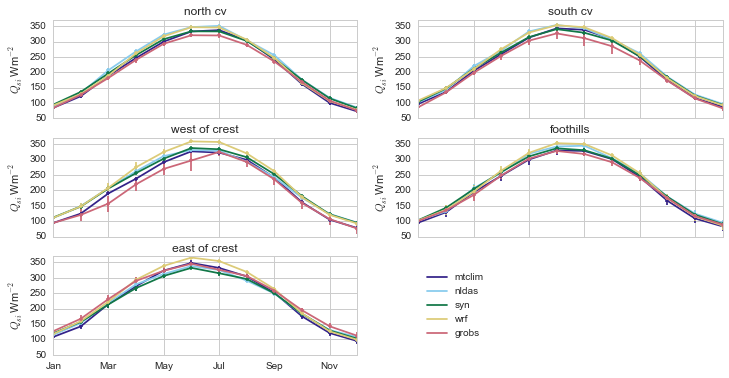

In [28]:
#### Monthly composite of annual cycle (Qsi)
colsche = kgraph.SRON(5)
f,axes = plt.subplots(3,2,sharex=True,figsize=(12,6))
pr_names_plot = ['mtclim','nldas','syn','wrf','grobs']
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for ax,gr in zip(axes.flatten(),grouping):
    for n,pr in enumerate(pr_names_plot):
        month_comp = grobs[pr].groupby('time.month').mean('time')
        month_comp_mean = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        month_comp_std = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].std('Grouping')
        ax.plot(month_comp_mean,label=pr,color=colsche[n])
        ax.errorbar(np.arange(0,12),month_comp_mean,yerr=month_comp_std,color=colsche[n],fmt='.')
    
    ax.set_xlim(0,11)
    ax.set_ylim(50,370)
    ax.set_xticklabels(month_label[::2])
    ax.set_title(gr)
    ax.set_ylabel('$Q_{si}$ Wm$^{-2}$')
    if ax == axes.flatten()[0]:
        handles, labels = ax.get_legend_handles_labels()
        axes[-1,-1].axis('off')
        axes[-1,-1].legend(handles, labels,loc='center left')

    # Output
os.chdir(dir_print)
fname = 'Composite.Qsi.png'
f.savefig(fname)

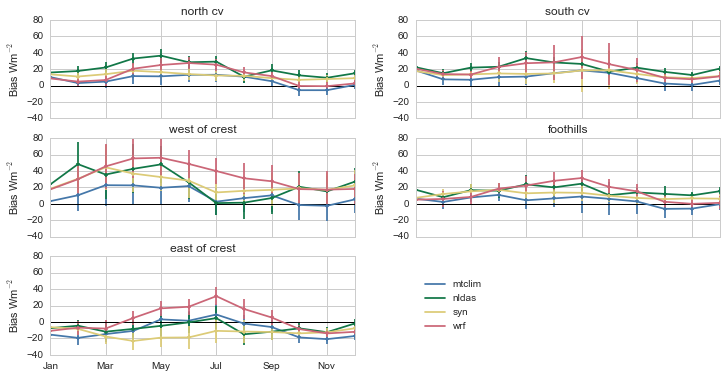

In [14]:
#### Monthly composite -- Qsi errors
f,axes = plt.subplots(3,2,sharex=True,figsize=(12,6))
pr_names_plot = ['mtclim','nldas','syn','wrf']
colsche = kgraph.SRON(len(pr_names_plot))
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for ax,gr in zip(axes.flatten(),grouping):
    ax.plot(np.array((0,13)),np.array((0,0)),linewidth=1,color='k')
    for n,pr in enumerate(pr_names_plot):
        month_comp = (grobs[pr]-grobs.grobs).groupby('time.month').mean('time')
        month_comp_mean = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        month_comp_std = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].std('Grouping')
        ax.plot(month_comp_mean,label=pr,color=colsche[n])
        ax.errorbar(np.arange(0,12),month_comp_mean,yerr=month_comp_std,color=colsche[n],fmt='.')
    
    ax.set_xlim(0,11)
    ax.set_ylim(-40,80)
    ax.set_xticklabels(month_label[::2])
    ax.set_title(gr)
    ax.set_ylabel('Bias Wm$^{-2}$')
    if ax == axes.flatten()[0]:
        handles, labels = ax.get_legend_handles_labels()
        axes[-1,-1].axis('off')
        axes[-1,-1].legend(handles, labels,loc='center left')

    # Output
os.chdir(dir_print)
fname = 'Composite.Qsi_Bias.png'
f.savefig(fname)

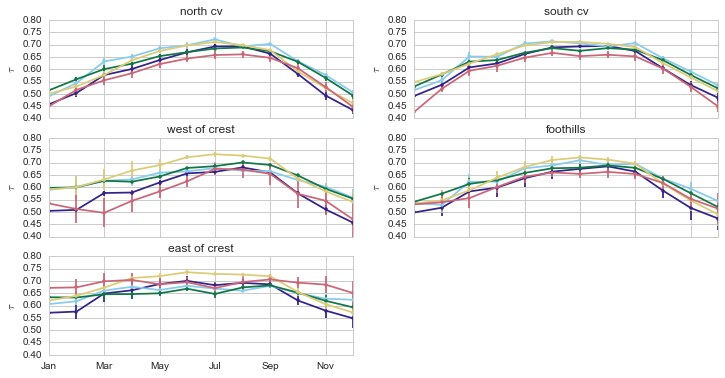

In [9]:
#### Monthly composite of annual cycle (Tau)
f,axes = plt.subplots(3,2,sharex=True,figsize=(12,6))
pr_names_plot = ['mtclim','nldas','syn','wrf','grobs']
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for ax,gr in zip(axes.flatten(),grouping):
    for n,pr in enumerate(pr_names_plot):
        month_comp = tau_products[pr].groupby('time.month').mean('time')
        month_comp_mean = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        month_comp_std = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].std('Grouping')
        ax.plot(month_comp_mean,label=pr,color=colsche[n])
        ax.errorbar(np.arange(0,12),month_comp_mean,yerr=month_comp_std,color=colsche[n],fmt='.')
    
    ax.set_xlim(0,11)
    ax.set_ylim(.4,.8)
    ax.set_xticklabels(month_label[::2])
    ax.set_title(gr)
    ax.set_ylabel('$\\tau$')
    if ax == axes.flatten()[0]:
        handles, labels = ax.get_legend_handles_labels()
        axes[-1,-1].axis('off')
        axes[-1,-1].legend(handles, labels,loc='center left')

# Output
os.chdir(dir_print)
fname = 'Composite.Tau.png'
f.savefig(fname)

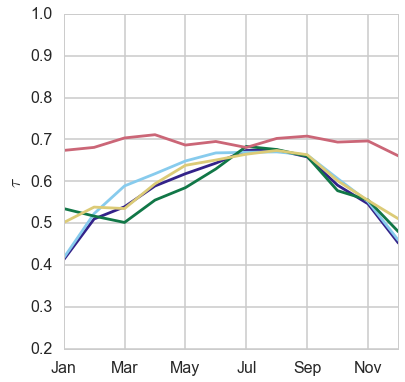

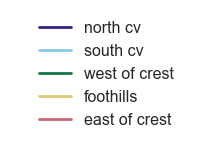

In [28]:
#### Monthly composite of annual cycle (Tau) -- Just observations
f,ax = plt.subplots(1,1,sharex=True,figsize=(6,6))
colsche = kgraph.SRON(len(grouping))
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

for n,gr in enumerate(grouping):
    if grouping == 'north cv' or grouping == 'south cv':
        month_comp = tau_products['grobs'].groupby('time.month').mean('time')
        month_comp_mean = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
    else:
        month_comp = tau_products['grobs'].sel(time=slice('2007-10-01', '2012-10-01'))
        month_comp = month_comp.groupby('time.month').mean('time')
        month_comp_mean = month_comp.swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
    
    ax.plot(month_comp_mean,label=gr,color=colsche[n])
    
    ax.set_xlim(0,11)
    ax.set_ylim(.2,1)
    ax.set_xticklabels(month_label[::2])
    ax.set_ylabel('$\\tau$')
        
# Output
os.chdir(dir_print)
fname = 'Grobs.Composite.Tau.pdf'
f.savefig(fname)

## Legend (separate figure)
leg_fig = plt.figure(figsize=(2.5,2))
leg_ax = plt.axes()
leg_ax.axis('off')
_out = leg_ax.legend(*ax.get_legend_handles_labels(),ncol=1, borderaxespad=0.)
os.chdir(dir_print)
fname = 'Grobs.Composite.Tau.Legend.pdf'
leg_fig.savefig(fname)


In [22]:
#### Time series: transmissivity

## Transmissivity by group
for gr in grouping:
    print(gr)
    ## tau for ground observations
    f = plt.figure(figsize=(4,3))
    tau_grobs = tau_products['grobs'].swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
    
    ## transmissivity of products
    f, axes = plt.subplots(2, num_products, figsize=(15,5),sharex='col', sharey='row')
    f.autofmt_xdate()
    for n,pr in enumerate(pr_names):
        # Mean transmissivity
        tau_plot = tau_products[pr].swap_dims({'station':'Grouping'}).loc[{'Grouping':gr}].mean('Grouping')
        
        ax = axes[0,n]
        ax.plot(tau_plot.time,tau_plot,'.',label='daily')
        ax.plot(tau_plot.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
                tau_plot.resample(freq='M',dim='time',how='mean').values,\
                'r',linewidth=3,label='monthly')
        ax.plot(tau_grobs.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
             tau_grobs.resample(freq='M',dim='time',how='mean'),'k',linewidth=3,label='obs',alpha=.6)

        ax.set_ylim(.2,.8)
        ax.set_xlim(datetime(2003,1,1),datetime(2013,1,1))
        ax.set_title(pr)
        if ax == axes[0,0]:
            ax.legend(loc='lower center',ncol=3,frameon=True,columnspacing=.3,handlelength=1)
        if n == 0:
            ax.set_ylabel('$\\tau$')
            
        # Difference from observed tau
        tau_diff = tau_plot-tau_grobs

        ax = axes[1,n]
        ax.plot(tau_diff.time,tau_diff,'.',label='daily')
        ax.plot(tau_diff.resample(freq='M',dim='time',how='mean').time-pd.Timedelta(days=15),\
                tau_diff.resample(freq='M',dim='time',how='mean').values,\
                'r',linewidth=2,label='monthly diff')
        ax.plot(np.array((datetime(2003,1,1),datetime(2013,1,1))),\
                np.ones(2)*np.nanmean(tau_diff.values),\
                'k',linewidth=3,alpha=.6,label='mean diff.')
        ax.plot(np.array((datetime(2003,1,1),datetime(2013,1,1))),np.array((0,0)),'k--')

        # Formatting and limits
        ax.set_ylim(-.15,.15)
        ax.set_xlim(datetime(2003,1,1),datetime(2013,1,1))
        
        if ax == axes[1,0]:
            ax.legend(loc='lower center',ncol=3,frameon=True,columnspacing=.3,handlelength=1)
        if n == 0:
            ax.set_ylabel('$\Delta$ $\\tau$')
        
    # Output
    os.chdir(dir_print)
    fname = 'Tau.'+gr+'.png'
    f.savefig(fname)

north cv


NameError: name 'tau_products' is not defined

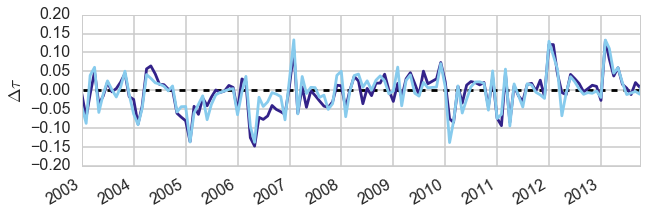

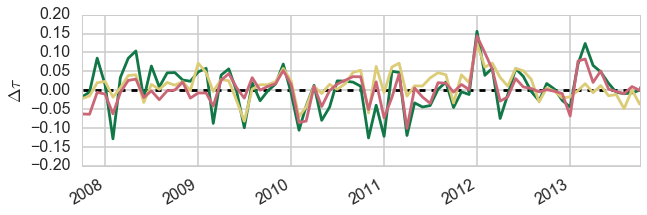

In [33]:
#### Time series of monthly anomaly in Tau
colsche = kgraph.SRON(5)

# North vs South (valley stations)
f,ax = plt.subplots(1,1,figsize=(10,3))
groups_for_plot = ['south cv','north cv']
ax.plot(np.array((anom_mon.time.values[0],anom_mon.time.values[-1])),np.zeros(2),'k--')
for n,gr in enumerate(groups_for_plot):
    ax.plot(anom_mon.time,anom_mon['mean'].loc[{'Grouping':gr}],\
             color=colsche[n],label=gr)
ax.set_xlim(datetime(2003,1,1),datetime(2013,10,1))
ax.set_ylim(-.2,.2)
ax.set_ylabel('$\Delta \\tau$')

# Output
os.chdir(dir_print)
fname = 'Tau.TimeSeries.Valley.pdf'
f.autofmt_xdate()
f.savefig(fname)

# East vs West (mountain stations)
f,ax = plt.subplots(1,1,figsize=(10,3))
groups_for_plot = ['west of crest','east of crest','foothills']
ax.plot(np.array((anom_mon.time.values[0],anom_mon.time.values[-1])),np.zeros(2),'k--')
for n,gr in enumerate(groups_for_plot):
    ax.plot(anom_mon.time,anom_mon['mean'].loc[{'Grouping':gr}],\
             color=colsche[n+2],label=gr)
ax.set_xlim(datetime(2007,10,1),datetime(2013,10,1))
ax.set_ylim(-.2,.2)
ax.set_ylabel('$\Delta \\tau$')

# Output
os.chdir(dir_print)
fname = 'Tau.TimeSeries.Mountain.pdf'
f.autofmt_xdate()
f.savefig(fname)

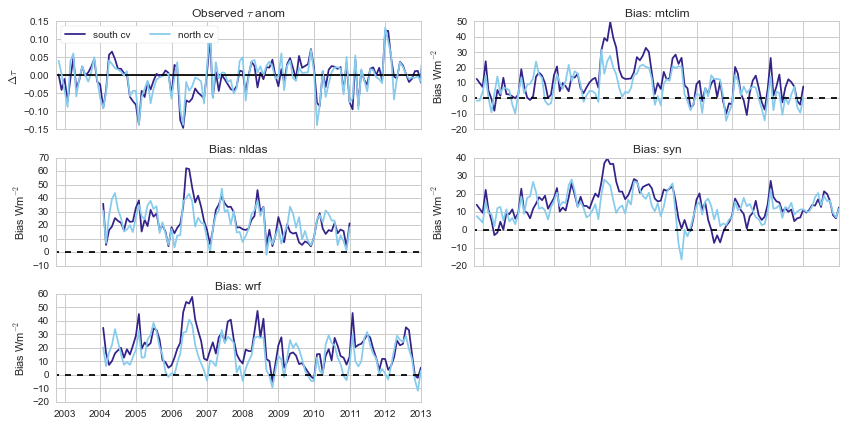

In [7]:
#### Product bias by group - Time series plot (valley)
colsche =   kgraph.SRON(5)
groups_for_plot = ['south cv','north cv']

f,axes = plt.subplots(3,2,sharex=True,figsize=(12,6))
axes = axes.flatten()
time_month = anom_mon.time

## Tau anomaly
ax = axes[0]
ax.plot(np.array((anom_mon.time.values[0],anom_mon.time.values[-1])),np.zeros(2),'k--')
for n,gr in enumerate(groups_for_plot):
    ax.plot(anom_mon.time,anom_mon['mean'].loc[{'Grouping':gr}],color=colsche[n],label=gr)

ax.legend(frameon=True,loc='best',ncol=2)
ax.set_ylim(-.15,.15)
ax.set_ylabel('$\Delta \\tau$')
ax.plot(np.array((datetime(2002,1,1),datetime(2016,1,1))),np.array((0,0)),'k--')
ax.set_xlim(np.array((datetime(2002,10,1),datetime(2013,1,1))))
ax.set_title('Observed $\\tau$ anom')

## Product bias with grobs group
for m,pr in enumerate(pr_names):
    ax = axes[m+1]
    for n,gr in enumerate(groups_for_plot):
        ax.plot(grobs_diff.resample(freq='M',dim='time',how='mean').time,\
                grobs_diff[pr].resample(freq='M',dim='time',how='mean').loc[{'Grouping':gr}],\
                color=colsche[n],label=gr)
    ax.set_ylabel('Bias Wm$^{-2}$')
    ax.set_title('Bias: '+pr)
    ax.plot(np.array((datetime(2002,1,1),datetime(2016,1,1))),np.array((0,0)),'k--')
    ax.set_xlim(np.array((datetime(2002,10,1),datetime(2013,1,1))))

axes[-1].axis('off')
plt.tight_layout()

# Output
os.chdir(dir_print)
fname = 'Tau_Bias.CV.png'
f.savefig(fname)

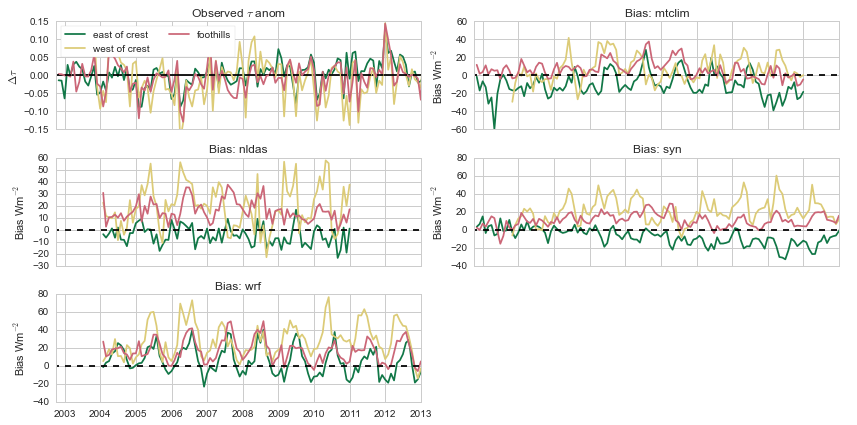

In [11]:
#### Product bias by group - Time series plot (mountain)
groups_for_plot = ['east of crest','west of crest','foothills']

f,axes = plt.subplots(3,2,sharex=True,figsize=(12,6))
axes = axes.flatten()
time_month = anom_mon.time

## Tau anomaly
ax = axes[0]
ax.plot(np.array((anom_mon.time.values[0],anom_mon.time.values[-1])),np.zeros(2),'k--')
for n,gr in enumerate(groups_for_plot):
    ax.plot(anom_mon.time,anom_mon['mean'].loc[{'Grouping':gr}],color=colsche[n+2],label=gr)

ax.legend(frameon=True,loc='best',ncol=2)
ax.set_ylim(-.15,.15)
ax.set_ylabel('$\Delta \\tau$')
ax.plot(np.array((datetime(2002,1,1),datetime(2016,1,1))),np.array((0,0)),'k--')
ax.set_xlim(np.array((datetime(2002,10,1),datetime(2013,1,1))))
ax.set_title('Observed $\\tau$ anom')

## Product bias with grobs group
for m,pr in enumerate(pr_names):
    ax = axes[m+1]
    for n,gr in enumerate(groups_for_plot):
        ax.plot(grobs_diff.resample(freq='M',dim='time',how='mean').time,\
                grobs_diff[pr].resample(freq='M',dim='time',how='mean').loc[{'Grouping':gr}],\
                color=colsche[n+2],label=gr)
    ax.set_ylabel('Bias Wm$^{-2}$')
    ax.set_title('Bias: '+pr)
    ax.plot(np.array((datetime(2002,1,1),datetime(2016,1,1))),np.array((0,0)),'k--')
    ax.set_xlim(np.array((datetime(2002,10,1),datetime(2013,1,1))))

axes[-1].axis('off')
plt.tight_layout()

# Output
os.chdir(dir_print)
fname = 'Tau_Bias.Mountain.png'
f.savefig(fname)

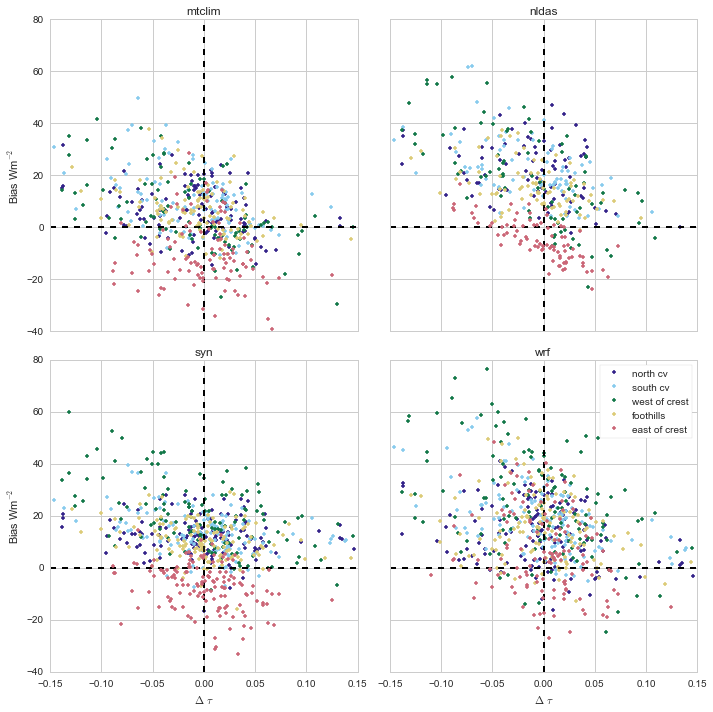

In [14]:
#### Tau anom vs bias - monthly (scatter plot)
colsche =   kgraph.SRON(5)
groups_for_plot = grouping

f,axes = plt.subplots(2,2,figsize=(10,10),sharex='col',sharey='row')
axes = axes.flatten()
for m,pr in enumerate(pr_names):
    ax = axes[m]
    for n,gr in enumerate(groups_for_plot):
        ax.plot(np.array((-.15,.15)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-40,80)),'k--')
        ax.plot(anom_mon['mean'].loc[{'Grouping':gr}],\
                grobs_diff[pr].resample(freq='M',dim='time',how='mean').loc[{'Grouping':gr}],\
                '.',color=colsche[n],label=gr)
    if np.mod(m,2) == 0:
        ax.set_ylabel('Bias Wm$^{-2}$')
    if m > 1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    ax.set_title(pr)
    ax.set_ylim(-40,80)
    ax.set_xlim(-.15,.15)

ax.legend(frameon=True)
plt.tight_layout()

# Output
os.chdir(dir_print)
fname = 'Tau_Bias.MonthlyScatter.png'
f.savefig(fname)

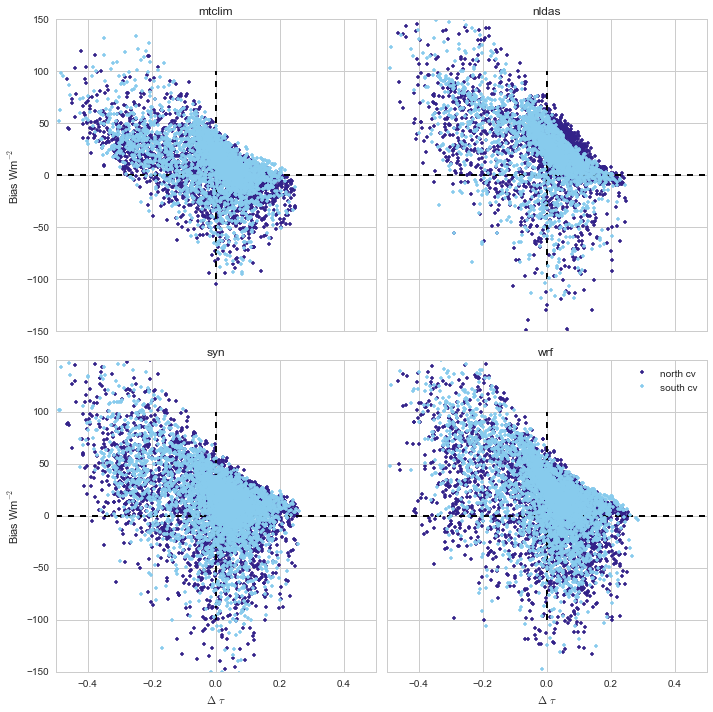

In [17]:
#### Tau anom vs bias - daily (scatter plot)
groups_for_plot = ['north cv','south cv']

f,axes = plt.subplots(2,2,figsize=(10,10),sharex='col',sharey='row')
axes = axes.flatten()
for m,pr in enumerate(pr_names):
    ax = axes[m]
    for n,gr in enumerate(groups_for_plot):
        ax.plot(np.array((-.5,.5)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-100,100)),'k--')
        ax.plot(anom_day['anom_mean'].loc[{'Grouping':gr}],\
                grobs_diff[pr].loc[{'Grouping':gr}],\
                '.',color=colsche[n],label=gr)
    if np.mod(m,2) == 0:
        ax.set_ylabel('Bias Wm$^{-2}$')
    if m > 1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    ax.set_title(pr)
    ax.set_ylim(-150,150)
    ax.set_xlim(-.5,.5)

ax.legend()
plt.tight_layout()

# Output
os.chdir(dir_print)
fname = 'Tau_Bias.DailyScatter.Valley.png'
f.savefig(fname)

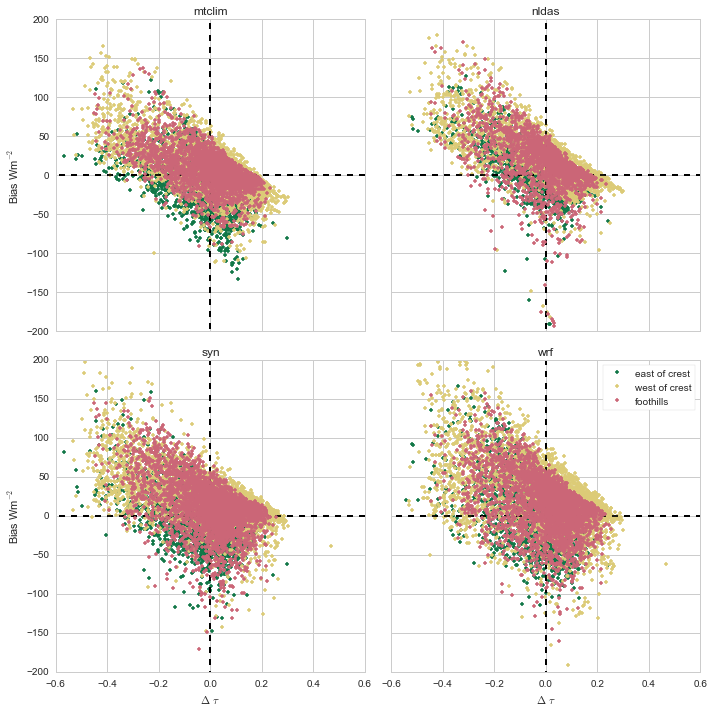

In [20]:
#### Tau anom vs bias - daily (scatter plot)
groups_for_plot = ['east of crest','west of crest','foothills']

f,axes = plt.subplots(2,2,figsize=(10,10),sharex='col',sharey='row')
axes = axes.flatten()
for m,pr in enumerate(pr_names):
    ax = axes[m]
    for n,gr in enumerate(groups_for_plot):
        ax.plot(np.array((-1,1)),np.array((0,0)),'k--')
        ax.plot(np.array((0,0)),np.array((-1000,1000)),'k--')
        ax.plot(anom_day['anom_mean'].loc[{'Grouping':gr}],\
                grobs_diff[pr].loc[{'Grouping':gr}],\
                '.',color=colsche[n+2],label=gr)
    if np.mod(m,2) == 0:
        ax.set_ylabel('Bias Wm$^{-2}$')
    if m > 1:
        ax.set_xlabel('$\Delta$ $\\tau$')
    ax.set_title(pr)
    ax.set_ylim(-200,200)
    ax.set_xlim(-.6,.6)

ax.legend(frameon=True)
plt.tight_layout()

# Output
os.chdir(dir_print)
fname = 'Tau_Bias.DailyScatter.Mnt.png'
f.savefig(fname)